# NIL BART Model

### (Google Colab Only) Check if you are using A100 or any GPU with 40GB

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug 17 19:44:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Load packages

In [3]:
# load needed libraries for google colab
!pip install transformers > /dev/null # without showing the output
!pip install datasets > /dev/null

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import sklearn.model_selection
from datasets import load_metric
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score, roc_curve)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          DataCollatorWithPadding)
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tokenizer and Model

In [ ]:
# load tokenizer and model
device = torch.device(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

checkpoint = 'facebook/bart-large-mnli'

tokenizer = AutoTokenizer.from_pretrained(checkpoint) # transformer AutoTokenizer

nli_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
# metric = load_metric("accuracy")

In [ ]:
nli_model.to(device)

BartForSequenceClassification(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): Layer

# Read data

In [ ]:
# read data
# train_data = pd.read_csv('/kaggle/input/factuality-train/factuality_train_.csv',encoding='ISO-8859-1')  # 读入训练集
# test_data = pd.read_csv('/kaggle/input/factuality-merge/Gen_review_test_factuality_2.csv',encoding='ISO-8859-1')  # 读入测试集

In [ ]:
# use merged data
raw_data = pd.read_csv('/content/drive/MyDrive/Internship/Code/codes/Gen_review_factuality.csv')

In [ ]:
raw_data.dropna(axis=0, how='any', inplace=True) # drop NA rows

In [ ]:
raw_data['label']= raw_data['label'].astype('int') # labels should be 0s and 1s

pid         object
doc         object
feedback    object
label        int64
dtype: object

In [ ]:
train_data, test_data = sklearn.model_selection.train_test_split(
      raw_data, test_size=0.3, random_state=666)  # USE raw_data

# Dataset Preparation

In [ ]:
class FeedbackDataset(Dataset):  # DataFrame
    def __init__(self,data):
        self.model_inputs = tokenizer(data['doc'].tolist(), data['feedback'].tolist(),
                                      max_length=1024,truncation='only_first', padding='max_length')
        self.model_inputs['labels'] = data['label'].tolist()

    def __getitem__(self, idx): # index
        return self.model_inputs['input_ids'][idx],
        self.model_inputs['attention_mask'][idx],
        self.model_inputs['labels'][idx]

    def __len__(self): # length
        return len(self.model_inputs['input_ids'])

# create Dataset type
train_dataset = FeedbackDataset(train_data)
test_dataset = FeedbackDataset(test_data)

In [ ]:
# process batches of data once they're retrieved from a DataLoader
def collate_batch(batch):
    input_ids_list = []
    attention_mask_list = []
    labels_list = []
    for item in batch:
        input_ids_list.append(item[0])  # doc
        attention_mask_list.append(item[1])  # attention_mask
        labels_list.append(item[2])  # labels

     # ensure that data is in the correct format and data type for input
    return {'input_ids':torch.LongTensor(input_ids_list).to(device),
            'attention_mask':torch.LongTensor(attention_mask_list).to(device),
            'labels':torch.LongTensor(labels_list).to(device)}


# Parameter Configuration

In [ ]:
bs = 1 # set the batch size

learning_rate = 1e-6 # set the initial learning rate

weight_decay = 1e-3 # set the initial weight_decay

num_epochs = 5 # set the number of epochs

weight_ratio = 2.718 # weight adjustment based on the inverse ratio of 0 and 1

# Data Preprocessing

In [ ]:
# load data
train_loader = DataLoader(dataset=train_dataset, batch_size=bs, collate_fn=collate_batch, shuffle=True) #  stochastic gradient descent # no order # 8 16
test_loader = DataLoader(dataset=test_dataset, batch_size=bs, collate_fn=collate_batch, shuffle=False)

In [ ]:
# raw_data['label'].value_counts()

1    1041
0     383
Name: label, dtype: int64

In [ ]:
# weight adjustment for unbalanced data set
weight = torch.tensor([weight_ratio, 1.0])
weight = weight.to(device)
print(weight)

tensor([2.7180, 1.0000], device='cuda:0')


# Model Training

In [ ]:
# function for calculating the loss (we are using testing dataset to validate for now)
def compute_validation_loss(nli_model, test_loader, loss_fct):
    val_loss = 0
    step = 0
    with torch.no_grad():
        for val_batch in test_loader:
            # forward
            outputs = nli_model(**val_batch)
            logits = outputs.get("logits")
            logits= logits[:,[0,2]]
            # compute loss
            labels = val_batch.get("labels")
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))
            step += 1
            val_loss += loss

    val_loss /= step
    return val_loss

# save the best model
def save_best_model(val_loss, min_val_loss, nli_model, best_model_state):
    if val_loss < min_val_loss:
        print(f'Validation loss decreased ({min_val_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        min_val_loss = val_loss
        best_model_state = copy.deepcopy(nli_model.state_dict())
    return min_val_loss, best_model_state


In [ ]:
# Training loop
nli_model.train()
# Initialize the optimizer
optimizer = torch.optim.AdamW(nli_model.parameters(), lr=learning_rate, weight_decay = weight_decay)

# Initialize the GradScaler for AMP
scaler = GradScaler()

# Initialize the early stopping counter
early_stopping_counter = 0
early_stopping_limit = 2  # Stop training after validation loss has not improved for 2 epochs

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2)

# Initialize the minimum validation loss
min_val_loss = float('inf')
# Initialize the minimum average validation loss for early stopping
min_avg_val_loss = float('inf')
# Initialize the best model state
best_model_state = copy.deepcopy(nli_model.state_dict())
# Set the validation interval
val_interval = 100

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    epoch_val_loss = 0.0  # sum of validation loss for the epoch
    val_checks = 0  # number of times validation loss is checked in the epoch

    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        # Use autocast for the forward pass
        with autocast():
            outputs = nli_model(**batch)
            logits = outputs.get("logits")
            logits= logits[:,[0,2]]  # only take entailment and contradiction, without neutral
            # compute loss
            loss_fct = nn.CrossEntropyLoss(weight=weight)
            labels = batch.get("labels")
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))

        # Use the scaler to scale the loss during backpropagation
        scaler.scale(loss).backward()

        # Use the scaler to step the optimizer and update the scale
        scaler.step(optimizer)
        scaler.update()

        # print average loss every 100 data or 100/bs batch
        running_loss += loss.item()
        if (i+1) % (100/bs) == 0:  # +1 to start counting from 1
            print('[%d, %5d] loss: %.3f' %(epoch+1, (i+1)*bs, running_loss/(100/bs)))
            train_losses.append(running_loss/(100/bs))
            running_loss = 0.0

            # compute validation loss
            val_loss = compute_validation_loss(nli_model, test_loader, loss_fct)
            print("Validation Loss: %.3f" % val_loss)
            valid_losses.append(val_loss.item())

            # Update the learning rate
            scheduler.step(val_loss)

            # Save the best model state
            min_val_loss, best_model_state = save_best_model(val_loss,
                                                             min_val_loss, nli_model, best_model_state) # save

            # Add the validation loss to the epoch sum and increment the number of checks
            epoch_val_loss += val_loss
            val_checks += 1


    # After the epoch, check the average validation loss for early stopping
    avg_val_loss = epoch_val_loss / val_checks
    print("Average validation loss for epoch: %.3f" % avg_val_loss)
    if avg_val_loss < min_avg_val_loss:  # Corrected condition
        min_avg_val_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_limit:
            print("Early stopping")
            # Load the best state of the model
            nli_model.load_state_dict(best_model_state)
            break

print('Finished Training')


[1,   100] loss: 0.799
Validation Loss: 0.632
Validation loss decreased (inf --> 0.632346).  Saving model ...
[1,   200] loss: 0.721
Validation Loss: 0.599
Validation loss decreased (0.632346 --> 0.599279).  Saving model ...
[1,   300] loss: 0.653
Validation Loss: 0.636
[1,   400] loss: 0.525
Validation Loss: 0.581
Validation loss decreased (0.599279 --> 0.581203).  Saving model ...
[1,   500] loss: 0.586
Validation Loss: 0.591
[1,   600] loss: 0.529
Validation Loss: 0.578
Validation loss decreased (0.581203 --> 0.577638).  Saving model ...
[1,   700] loss: 0.652
Validation Loss: 0.585
[1,   800] loss: 0.621
Validation Loss: 0.573
Validation loss decreased (0.577638 --> 0.572562).  Saving model ...
[1,   900] loss: 0.598
Validation Loss: 0.560
Validation loss decreased (0.572562 --> 0.560291).  Saving model ...
Average validation loss for epoch: 0.593
[2,   100] loss: 0.571
Validation Loss: 0.554
Validation loss decreased (0.560291 --> 0.553852).  Saving model ...
[2,   200] loss: 0.52

# Model testing

In [ ]:
# Testing loop
nli_model.eval()
num_batches = len(test_loader) # The number of the batches
test_loss = 0

test=[]
prob=[]
pred=[]
with torch.no_grad():
    for i,batch in enumerate(test_loader):
        # Forward
        labels = batch.get("labels")
        outputs = nli_model(**batch)
        logits = outputs.get("logits")
        logits= logits[:,[0,2]]
        # Compute loss
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))
        test_loss += loss

        # Softmax normalization
        logits=nn.functional.softmax(logits,dim=1)
        # The probability of predicting as label 1
        prob.extend(logits[:,1].tolist())
        # Choose the largest value of the logits to be the predicted label
        pred.extend(logits.argmax(dim=1).tolist())
        # Ture label
        test.extend(labels.tolist())

    test_loss /= num_batches # loss
print("true labels: ",test)
print("prob: ",prob)
print("predicted labels: ",pred)
print(f"Test: \n Avg loss: {test_loss:>8f} \n")

true labels:  [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0

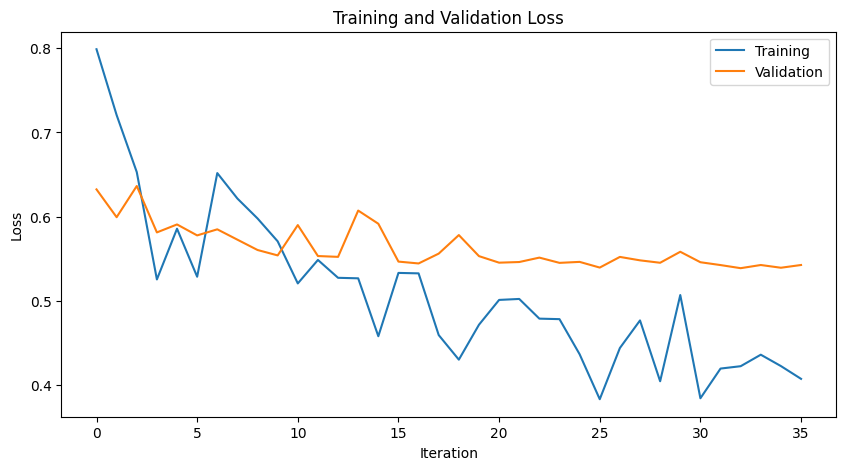

In [ ]:
# Visualize loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(range(len(train_losses)), train_losses, label="Training")
plt.plot(range(len(valid_losses)), valid_losses, label="Validation")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Model Evaluation

In [ ]:
print("confusion matrix:\n", confusion_matrix(test,pred))
print("accuracy: ",accuracy_score(test,pred))
print("recall: ",recall_score(test,pred))
print("precison: ", precision_score(test,pred))
print("F1: ",f1_score(test,pred))
print("AUC: ", roc_auc_score(test, prob))

confusion matrix:
 [[ 38  78]
 [ 34 278]]
accuracy:  0.7383177570093458
recall:  0.8910256410256411
precison:  0.7808988764044944
F1:  0.8323353293413175
AUC:  0.7013980990274095


In [ ]:
print(classification_report(test, pred))

              precision    recall  f1-score   support

           0       0.53      0.33      0.40       116
           1       0.78      0.89      0.83       312

    accuracy                           0.74       428
   macro avg       0.65      0.61      0.62       428
weighted avg       0.71      0.74      0.72       428



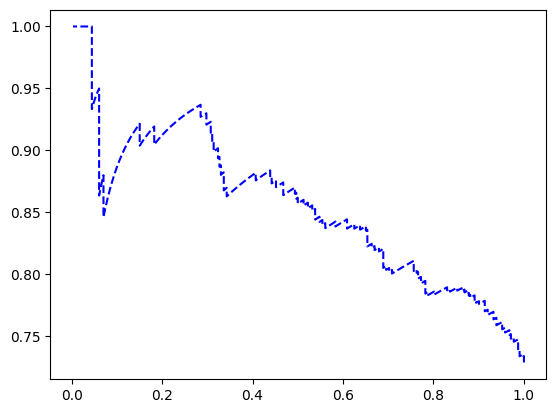

In [ ]:

# Plot PR Curve
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], 'b--')

precisions, recalls, thresholds = precision_recall_curve(test, prob)
plot_precision_recall(precisions, recalls)
plt.show()

In [ ]:
pr_auc_score = auc(recalls, precisions)
print(pr_auc_score)